# Neural Dual Solver 

This tutorial shows how to use `OTT` to compute the Wasserstein-2 optimal transport map between continuous measures in Euclidean space that are accessible via sampling.
{class}`~ott.solvers.nn.neuraldual.W2NeuralDual` solves this
problem by optimizing parameterized Kantorovich dual potential functions
and returning a  {class}`~ott.problems.linear.potentials.DualPotentials`
object that can be used to transport unseen source data samples to its target distribution (or vice-versa) or compute the corresponding distance between new source and target distribution.

The dual potentials can be specified as non-convex neural networks
({class}`~ott.solvers.nn.models.MLP`) or an
input-convex neural network ({class}`~ott.solvers.nn.models.ICNN`) {cite}`amos:17`.
{class}`~ott.solvers.nn.neuraldual.W2NeuralDual` implements the
method developed by {cite}`makkuva:20`
along with the improvements and fine-tuning of the
conjugate computation from {cite}`amos:23`.
For more insights on the approach itself, we refer the user
to the original sources.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
from dataclasses import dataclass
from functools import partial

import jax
import jax.numpy as jnp
import numpy as np
import optax
from torch.utils.data import DataLoader, IterableDataset

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from ott.geometry import pointcloud
from ott.problems.linear import potentials
from ott.problems.nn import dataset
from ott.solvers.nn import models, neuraldual
from ott.tools import plot, sinkhorn_divergence

## Setup training and validation datasets

We apply the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` to compute the transport between toy datasets.
Here, we aim at computing the map between two toy datasets representing both, source and target distribution using the
datasets `simple` (data clustered in one center) and `circle` (two-dimensional Gaussians arranged on a circle) from {class}`~ott.problems.nn.dataset.GaussianMixture`.

In order to solve the neural dual, we need to define our dataloaders. The only requirement is that the corresponding source and target train and validation datasets are *iterators* that provide samples of batches from the source and target measures.
The following command loads them with OTT's pre-packaged loader for synthetic data.

In [3]:
num_samples_visualize = 400
(
    train_dataloaders,
    valid_dataloaders,
    input_dim,
) = dataset.create_gaussian_mixture_samplers(
    name_source="simple",
    name_target="circle",
    valid_batch_size=num_samples_visualize,
)

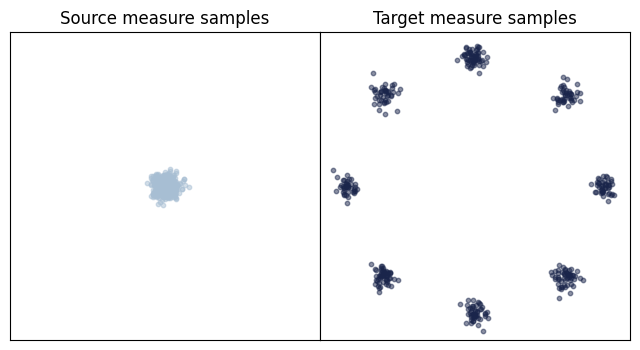

In [4]:
def plot_samples(eval_data_source, eval_data_target):
    fig, axs = plt.subplots(
        1, 2, figsize=(8, 4), gridspec_kw={"wspace": 0, "hspace": 0}
    )
    axs[0].scatter(
        eval_data_source[:, 0],
        eval_data_source[:, 1],
        color="#A7BED3",
        s=10,
        alpha=0.5,
    )
    axs[0].set_title("Source measure samples")
    axs[1].scatter(
        eval_data_target[:, 0],
        eval_data_target[:, 1],
        color="#1A254B",
        s=10,
        alpha=0.5,
    )
    axs[1].set_title("Target measure samples")

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(-6, 6)
        ax.set_ylim(-6, 6)
    return fig, ax


# Sample a batch for evaluation and plot it
eval_data_source = next(valid_dataloaders.source_iter)
eval_data_target = next(valid_dataloaders.target_iter)

plot_samples(eval_data_source, eval_data_target);

Next, we define the architectures parameterizing the dual potentials $f$ and $g$. We first parameterize $f$ with an {class}`~ott.solvers.nn.models.ICNN` and $\nabla g$ as a non-convex {class}`~ott.solvers.nn.models.MLP`. You can adapt the size of the ICNNs by passing a sequence containing hidden layer sizes. While ICNNs are by default containing partially positive weights, we can run the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` using approximations to this positivity constraint (via weight clipping and a weight penalization).
For this, set `pos_weights` to `True` in {class}`~ott.solvers.nn.models.ICNN` and {class}`~ott.solvers.nn.neuraldual.W2NeuralDual`.
For more details on how to customize {class}`~ott.solvers.nn.models.ICNN`,
we refer you to the documentation.

In [5]:
# initialize models and optimizers
num_train_iters = 5001

neural_f = models.ICNN(dim_data=2, dim_hidden=[64, 64, 64, 64])
neural_g = models.MLP(
    dim_hidden=[64, 64, 64, 64],
    is_potential=False,  # returns the gradient of the potential.
)

lr_schedule = optax.cosine_decay_schedule(
    init_value=1e-4, decay_steps=num_train_iters, alpha=1e-2
)
optimizer_f = optax.adam(learning_rate=lr_schedule, b1=0.5, b2=0.5)
optimizer_g = optax.adam(learning_rate=lr_schedule, b1=0.9, b2=0.999)

## Train Neural Dual

We then initialize the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` by passing the two {class}`~ott.solvers.nn.models.ICNN` models parameterizing $f$ and $g$, as well as by specifying the input dimensions of the data and the number of training iterations to execute. Once the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` is initialized, we can obtain the neural {class}`~ott.problems.linear.potentials.DualPotentials` by passing the corresponding dataloaders to it.

<font color='#F2545B'>Execution of the following cell will probably take a few minutes, depending on your system and the number of training iterations.</font>

In [6]:
def training_callback(step, learned_potentials):
    # Callback function as the training progresses to visualize the couplings.
    if step % 1000 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=True,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=False,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_potential()
        display(fig)
        plt.close(fig)


neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
)
learned_potentials = neural_dual_solver(
    *train_dataloaders,
    *valid_dataloaders,
    callback=training_callback,
)
clear_output()

The output of the solver, `learned_potentials`, is an instance of {class}`~ott.problems.linear.potentials.DualPotentials`. This  gives us access to the learned potentials and provides functions to compute and plot the forward and inverse OT maps between the measures.

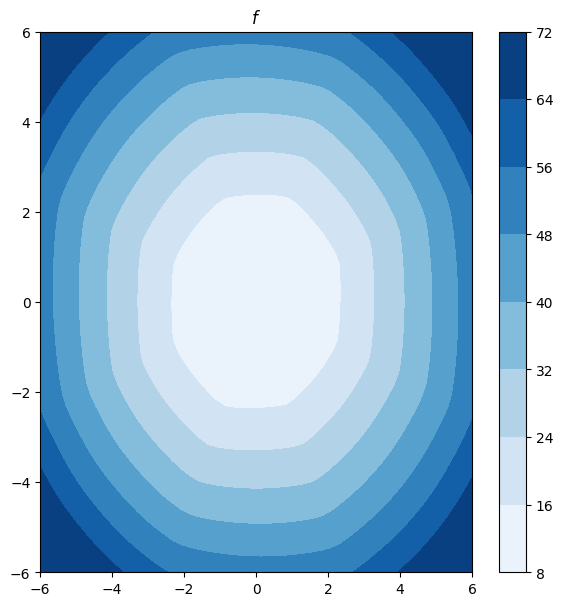

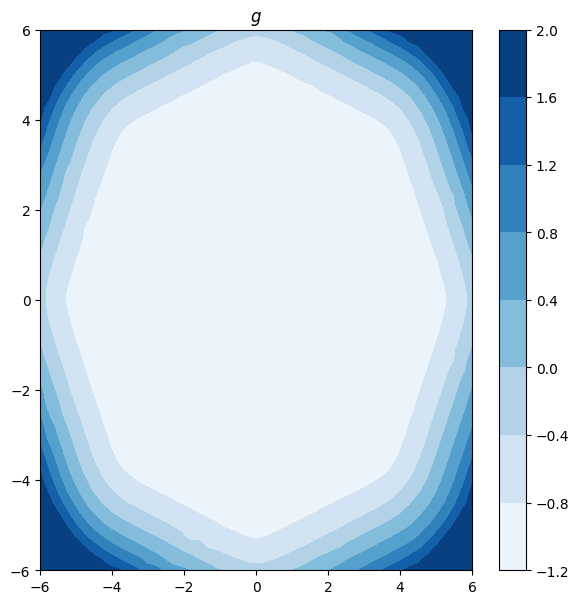

In [7]:
learned_potentials.plot_potential(forward=True)
learned_potentials.plot_potential(forward=False);

## Evaluate Neural Dual

After training has completed successfully, we can evaluate the neural {class}`~ott.problems.linear.potentials.DualPotentials` on unseen incoming data. We first sample a new batch from the source and target distribution.

Now, we can plot the corresponding transport from source to target using the gradient of the learning potential $g$, i.e., $\nabla g(\text{source})$, or from target to source via the gradient of the learning potential $f$, i.e., $\nabla f(\text{target})$.

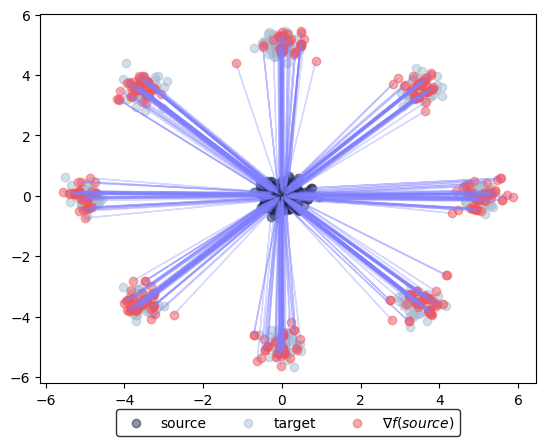

In [8]:
learned_potentials.plot_ot_map(
    eval_data_source,
    eval_data_target,
    forward=True,
);

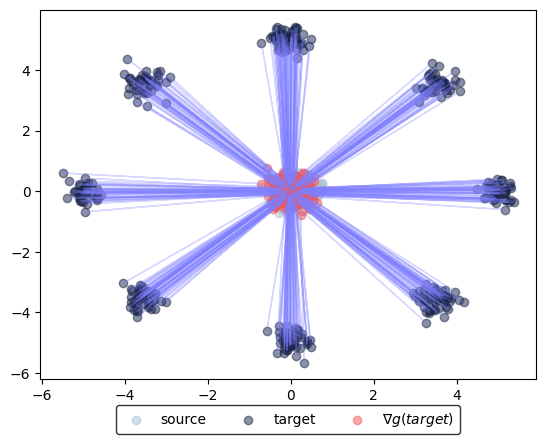

In [9]:
learned_potentials.plot_ot_map(
    eval_data_source, eval_data_target, forward=False
);

We further test, how close the predicted samples are to the sampled data.

First for potential $g$, transporting source to target samples. Ideally the resulting {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` distance is close to $0$.

In [10]:
@jax.jit
def sinkhorn_loss(x, y, epsilon=0.1):
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    sdiv = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    return sdiv.divergence

In [11]:
pred_target = learned_potentials.transport(eval_data_source)
print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_loss(pred_target, eval_data_target):.2f}"
)

Sinkhorn distance between source predictions and data samples: 0.83


Then for potential $f$, transporting target to source samples. Again, the resulting {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` distance needs to be close to $0$.

In [12]:
pred_source = learned_potentials.transport(eval_data_target, forward=False)
print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_loss(pred_source, eval_data_source):.2f}"
)

Sinkhorn distance between source predictions and data samples: 0.00


Besides computing the transport and mapping source to target samples or vice versa, we can also compute the overall distance between new source and target samples.

In [13]:
neural_dual_dist = learned_potentials.distance(
    eval_data_source, eval_data_target
)
print(
    f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
)

Neural dual distance between source and target data: 21.95


Which compares to the primal {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` distance in the following.

In [14]:
sinkhorn_dist = sinkhorn_loss(eval_data_source, eval_data_target)
print(f"Sinkhorn distance between source and target data: {sinkhorn_dist:.2f}")

Sinkhorn distance between source and target data: 22.00


## Solving a harder problem

We next set up a harder OT problem to transport from a mixture
of five Gaussians to a mixture of four Gaussians and solve
it by using the non-convex {class}`~ott.solvers.nn.models.MLP`
potentials to model $f$ and $g$.

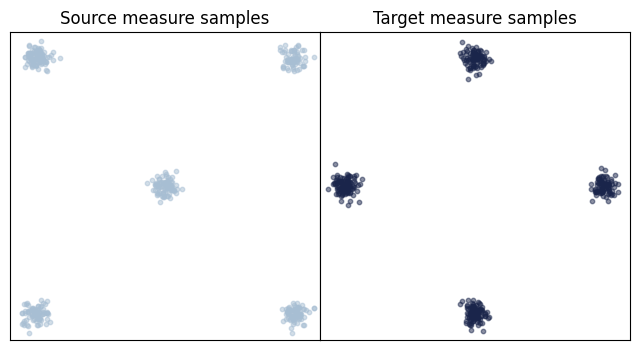

In [15]:
(
    train_dataloaders,
    valid_dataloaders,
    input_dim,
) = dataset.create_gaussian_mixture_samplers(
    name_source="square_five",
    name_target="square_four",
    valid_batch_size=num_samples_visualize,
)

eval_data_source = next(valid_dataloaders.source_iter)
eval_data_target = next(valid_dataloaders.target_iter)
plot_samples(eval_data_source, eval_data_target);

In [16]:
num_train_iters = 20001

neural_f = models.MLP(dim_hidden=[64, 64, 64, 64])
neural_g = models.MLP(dim_hidden=[64, 64, 64, 64])

lr_schedule = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-2
)
optimizer_f = optax.adamw(learning_rate=lr_schedule)
optimizer_g = optimizer_f

neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
)
learned_potentials = neural_dual_solver(
    *train_dataloaders,
    *valid_dataloaders,
    callback=training_callback,
)
clear_output()

We can run the same visualizations and Wasserstein-2 distance estimations as before:

Sinkhorn distance between target predictions and data samples: 1.76
Sinkhorn distance between source predictions and data samples: 1.94
Neural dual distance between source and target data: 21.01
Sinkhorn distance between source and target data: 21.20


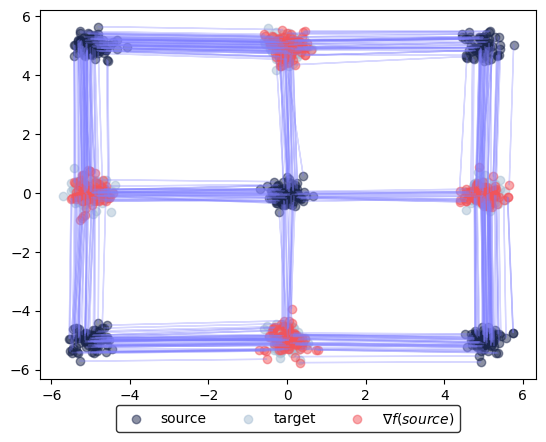

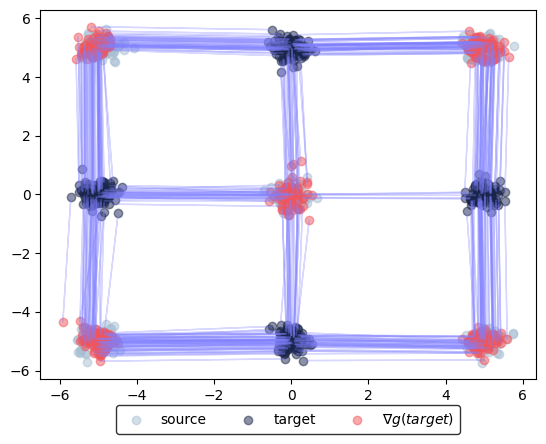

In [17]:
learned_potentials.plot_ot_map(eval_data_source, eval_data_target, forward=True)
learned_potentials.plot_ot_map(
    eval_data_source, eval_data_target, forward=False
)

pred_target = learned_potentials.transport(eval_data_source)
print(
    f"Sinkhorn distance between target predictions and data samples: {sinkhorn_loss(pred_target, eval_data_target):.2f}"
)


pred_source = learned_potentials.transport(eval_data_target, forward=False)
print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_loss(pred_source, eval_data_source):.2f}"
)

neural_dual_dist = learned_potentials.distance(
    eval_data_source, eval_data_target
)
print(
    f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
)

sinkhorn_dist = sinkhorn_loss(eval_data_source, eval_data_target)
print(f"Sinkhorn distance between source and target data: {sinkhorn_dist:.2f}")

The next portion computes the optimal transport maps between other
synthetic 2D datasets from [scikit-learn](https://scikit-learn.org/stable/index.html).

In [18]:
def solve_and_plot(
    source_name, target_name, ax, num_train_iters=20001, batch_size=4096
):
    try:
        from w2ot import data
    except ImportError:
        print(
            "Please install the w2ot package from "
            "https://github.com/facebookresearch/w2ot "
            "for the scikit-learn dataloaders"
        )
        raise

    pair_data = data.Pair2d(
        mu=source_name, nu=target_name, batch_size=batch_size
    )
    source_sampler, target_sampler = pair_data.load_samplers()

    def sampler_iter(sampler):
        key = jax.random.PRNGKey(0)
        while True:
            k1, key = jax.random.split(key, 2)
            yield sampler.sample(key=k1, batch_size=batch_size)

    source_sampler = sampler_iter(source_sampler)
    target_sampler = sampler_iter(target_sampler)
    train_dataloaders = (source_sampler, target_sampler)
    valid_dataloaders = train_dataloaders

    input_dim = 2

    neural_f = models.MLP(dim_hidden=[64, 64, 64, 64])
    neural_g = models.MLP(dim_hidden=[64, 64, 64, 64])

    lr_schedule = optax.cosine_decay_schedule(
        init_value=5e-4, decay_steps=num_train_iters, alpha=1e-2
    )
    optimizer_f = optax.adamw(learning_rate=lr_schedule)
    optimizer_g = optimizer_f

    neural_dual_solver = neuraldual.W2NeuralDual(
        input_dim,
        neural_f,
        neural_g,
        optimizer_f,
        optimizer_g,
        num_train_iters=num_train_iters,
    )
    learned_potentials = neural_dual_solver(
        *train_dataloaders,
        *valid_dataloaders,
    )

    eval_data_source = next(source_sampler)[:num_samples_visualize]
    eval_data_target = next(target_sampler)[:num_samples_visualize]
    learned_potentials.plot_ot_map(
        eval_data_source, eval_data_target, forward=False, ax=ax
    )
    ax.get_legend().remove()
    ax.axis("equal")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor("white")
    plt.setp(ax.spines.values(), color="k")
    display(ax.get_figure())

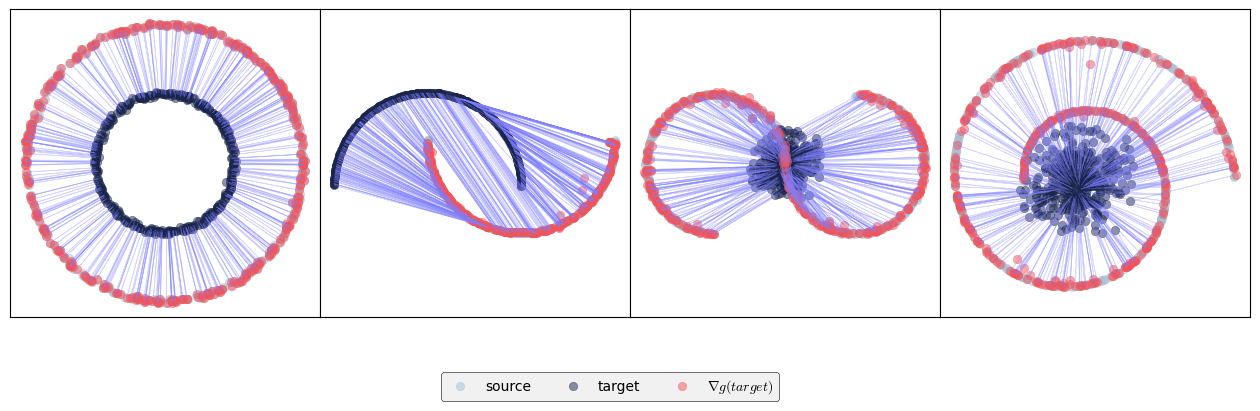

In [19]:
nrow, ncol = 1, 4
fig, axs = plt.subplots(nrow, ncol, figsize=(4 * ncol, 4 * nrow))
solve_and_plot("sk_circle_big", "sk_circle_small", axs[0], num_train_iters=2001)
fig.legend(
    ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.01), edgecolor="k"
)
solve_and_plot("sk_moon_lower", "sk_moon_upper", axs[1])
solve_and_plot("sk_s_curve", "gauss_1_unit", axs[2])
solve_and_plot("sk_swiss", "gauss_1_unit", axs[3])
fig.subplots_adjust(wspace=0, hspace=0)
clear_output();